#**Synthetic Data Generation for SQL Commands**

This notebook demonstrates an automated approach to synthetic data generation for instruction-response datasets, where each instruction (or question) is paired with a corresponding SQL command as a response. The goal is to streamline the process of creating datasets that can be used for fine-tuning AI models capable of understanding and producing SQL commands from natural language instructions.

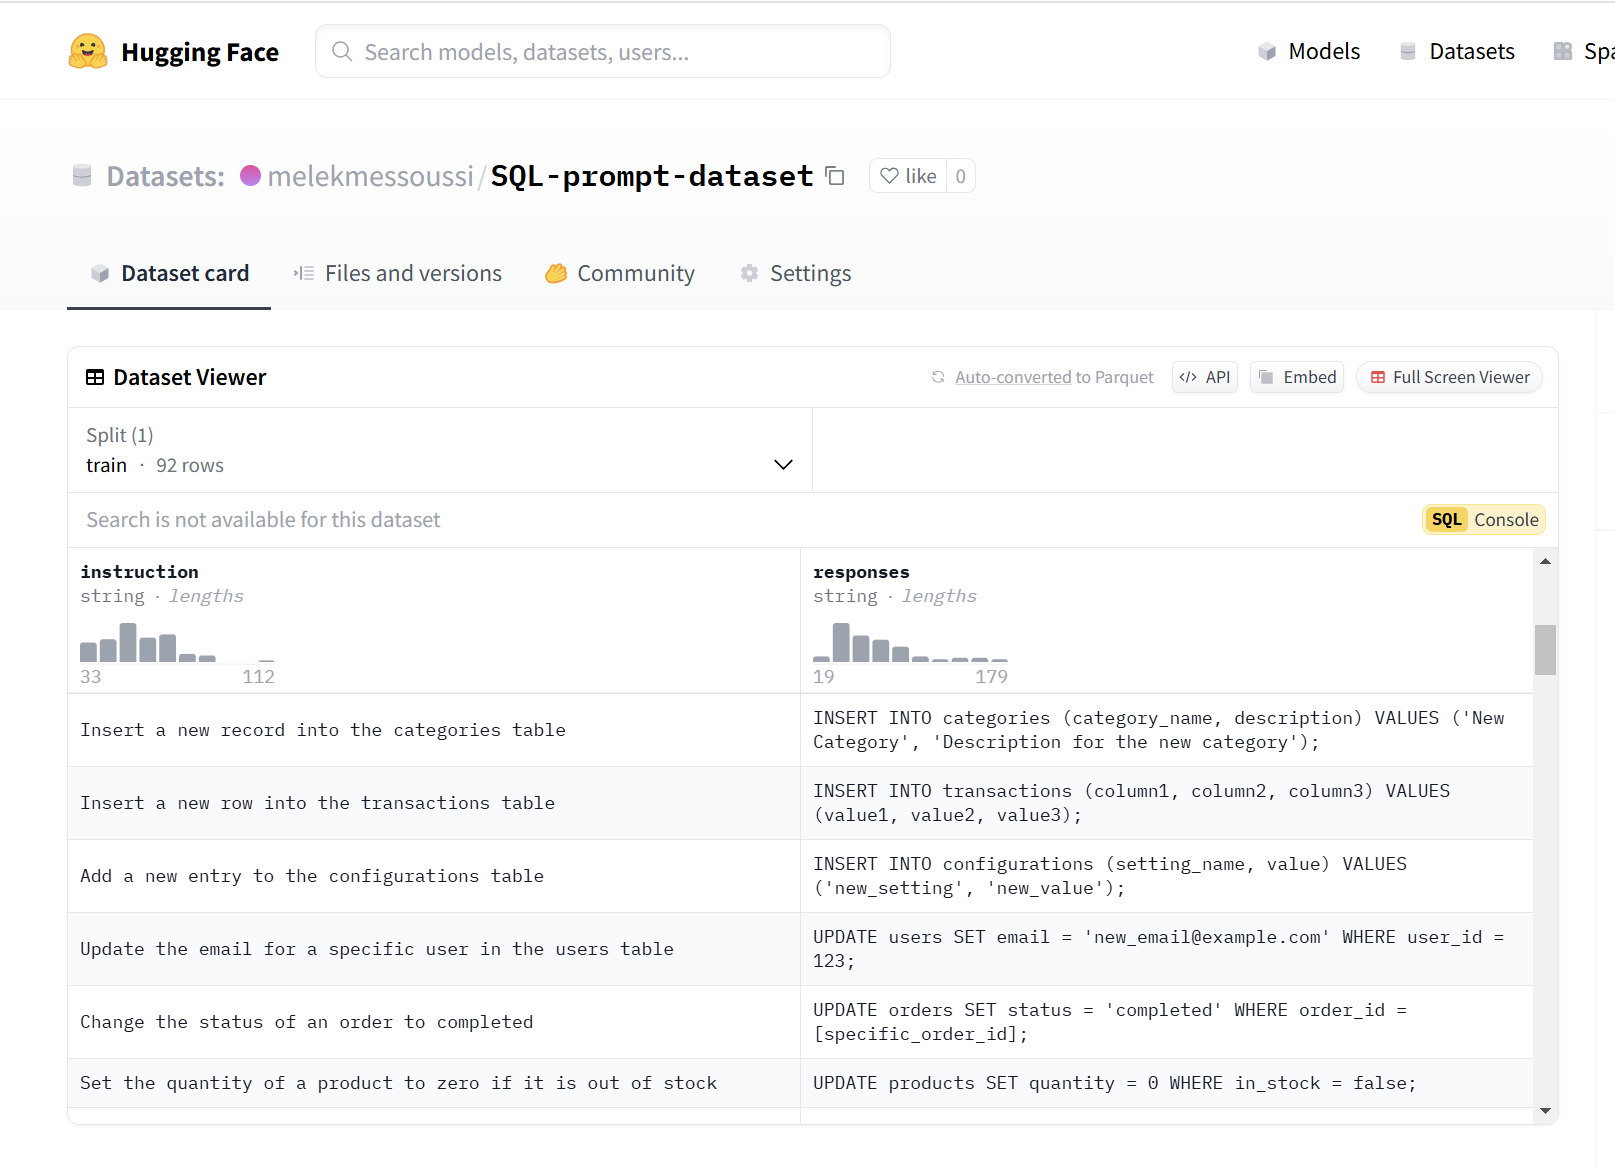

### **Why Do We Generate Data?**

Data is all around us, it's the foundation for making decisions, powering AI models, and shaping the future of businesses, organizations, and society. But sometimes, real-world data isn’t easy to access. It could be difficult to collect, too expensive to obtain, or too sensitive to use.

This is where synthetic data comes into play. It’s computer-generated data that mimics the structure and patterns of real-world data, offering a solution that lets us explore and analyze insights without the risks associated with using actual, sensitive information.

Here’s why generating synthetic data is so important:

- **Fine-Tuning AI Models:** The synthetic datasets we create are perfect for fine-tuning AI models, helping them understand various tasks like natural language processing and SQL command generation, without the need for large volumes of real-world data.

- **Cost and Time Efficiency:** Generating synthetic data saves significant time and resources compared to manually collecting and curating real-world datasets. This method ensures high-quality results without the hassle.

- **Broad AI Applications:** Synthetic data isn't just for training models; it’s also used for testing, data augmentation, and benchmarking. By providing a diverse set of examples, synthetic data helps AI models generalize better, ultimately leading to improved real-world performance.

Synthetic data is a game-changer, offering a practical, efficient, and secure way to enhance AI systems and unlock new possibilities across industries.


##**How It Works**  
Here’s the game plan:


* **Subtopic Generation**: Prompt the model to generate SQL-related subtopics like Data Retrieval, Joins, Aggregations, etc.  

* **Instruction Generation**: For each subtopic, prompt the model to create natural language instructions or questions.  

* **SQL Response Generation**: Prompt the model to generate SQL commands corresponding to each instruction.  

* **Dataset Filtering**: Use a reward model to filter out low-quality instruction-SQL pairs, ensuring only relevant responses are retained.  


#**Let's Get Started!**

## **Step 1: Setting Up the Environment**  

We prepare the environment by installing necessary libraries and establishing a connection to Hugging Face's Inference API. This setup allows us to access the **Qwen2.5-72B-Instruct** model, which I chose for its ability to generate SQL commands directly without any additional text when prompted. By creating a dataset from its responses, we can fine-tune a model on its answering style, ensuring high-quality SQL command generation. (You can pick any other model for your used case)


In [ ]:
%%capture
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="")
MODEL = "Qwen/Qwen2.5-72B-Instruct"

## **Step 2: Generating Subtopics**

Here, we focus on generating a set of subtopics related to the broader topic of SQL commands. The goal is to create a list of distinct SQL categories that we can later use to generate natural language instructions and corresponding SQL queries. While I chose SQL commands as the focus for this project, you could easily adapt this approach to generate subtopics for any other area of interest.

- **Prompt Template:** We define a prompt that asks the model to generate a list of subtopics related to SQL commands. The prompt specifies that the subtopics should be general categories (such as "Data Manipulation" or "Joins") and must not include numbers, descriptions, or any extraneous text.

- **Generating Subtopics:** Using the Hugging Face InferenceClient, we pass the prompt to the **Qwen2.5-72B-Instruct** model, which generates a list of subtopics. In our example, we are asking for **10** subtopics related to SQL commands, but you can adjust this number.

By generating these subtopics, we lay the foundation for the rest of the notebook.


In [ ]:
n_subtopics = 10
TOPIC_GENERATION_PROMPT_TEMPLATE = """\
I want to create a synthetic dataset of natural language and SQL commands. Based on this context, give me {n_subtopics} general subtopics to cover
that are diffrent sql command categories.

The list must be without numbers, and without any description of the subtopics. The subtopics should be separated by a comma. There must be no other text than the list and no ().
"""

In [ ]:
def generate_subtopics(client, n_subtopics):
    prompt = TOPIC_GENERATION_PROMPT_TEMPLATE.format(n_subtopics=n_subtopics)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user",
             "content": prompt}
        ],
        temperature=0.2,
        top_p=0.7,
    )
    return response

In [ ]:
responses = generate_subtopics(client, n_subtopics=n_subtopics)
print(responses.choices[0].message.content)

Data Retrieval, Data Manipulation, Data Definition, Data Control, Transaction Control, Query Optimization, Error Handling, Security Management, Index Management, View Management


## **Step 3: Generating Instructions**

Now that we have our subtopics, the next step is to generate natural language instructions related to each of those subtopics. These instructions are meant to be concise queries or requests that would correspond to SQL commands, serving as the basis for generating synthetic datasets.

- **Prompt Template for Instruction Generation:** We define a template that asks the model to generate **n_instructions** related to a specific SQL subtopic. The instructions should be simple and clear, with some written as if they come from a beginner or someone with limited SQL knowledge. This helps ensure the instructions are realistic and can mimic real user interactions.

- **Generating Instructions:** For each subtopic (like "Data Manipulation" or "Joins"), we pass the template to the **Qwen2.5-72B-Instruct** model. The model generates a list of instructions in natural language.

- **Processing Multiple Subtopics:** We apply the instruction generation function to all the subtopics generated earlier. For each subtopic, we get a list of instructions that we then format into a single, unified list.

This step ensures that we have a variety of instructions for each SQL subtopic.


In [ ]:
n_instructions = 20
INSTRUCTION_PROMPT_TEMPLATE = """\
The objective is to create a dataset of user instructions in natural language that should be returned by SQL commands.
Given a topic in SQL, generate {n_instructions} possible concise instructions that could be given to an AI assistant about that topic.
Write some of these instructions as if given by someone with limited knowledge of SQL terminologies and knowledge,
like a beginner programmer. Your response should be in a list format.

The topic is: {sub_topic}
The list must be without numbers or any special character. The questions/instructions should be separated by a newline character. There must be no other text than the list.
"""

In [ ]:
subtopic_list = responses.choices[0].message.content.split(",")

In [ ]:
def generate_instructions(client, sub_topic, n_instructions):
    print(f"Generating Instructions for {sub_topic}.")
    prompt = INSTRUCTION_PROMPT_TEMPLATE.format(sub_topic=sub_topic, n_instructions=n_instructions)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user",
             "content": prompt}
        ],
        temperature=0.2,
        top_p=0.7,
    )
    return response.choices[0].message.content

def instructions_generator(client, subtopic_list, n_instructions):
    instruction_list = [generate_instructions(client, subtopic, n_instructions) for subtopic in subtopic_list]
    return instruction_list

In [ ]:
instruction_list = instructions_generator(client, subtopic_list, n_instructions)

instruction_list_formatted = []
for instruction_set in instruction_list:
    instruction_list_formatted.extend([instruction.strip() for instruction in instruction_set.split("\n") if instruction])


Generating Instructions for Data Retrieval.
Generating Instructions for  Data Manipulation.
Generating Instructions for  Data Definition.
Generating Instructions for  Data Control.
Generating Instructions for  Transaction Control.
Generating Instructions for  Query Optimization.
Generating Instructions for  Error Handling.
Generating Instructions for  Security Management.
Generating Instructions for  Index Management.
Generating Instructions for  View Management.


The final result is a list of instructions that are ready to be paired with corresponding SQL queries, forming the foundation of the dataset.

In [ ]:
instruction_list_formatted[:6]

['Show me all the records from the customers table',
 'Can you get me the names and emails of all users',
 'I need to see the total number of orders placed',
 'Could you list all products that are out of stock',
 'How do I find the highest price in the products table',
 'Can you pull the data for customers who made more than one purchase']

## **Step 4: Generating Responses**

Once we have our instructions ready, the next step is to generate the SQL commands that correspond to each of those instructions. The idea is to take each natural language instruction and get a precise SQL query as the response.

- **Response Prompt Template:** We define a prompt template that asks the model to generate the SQL command based on a given instruction. The model is specifically instructed to provide only the SQL query, with no additional explanation or text. This ensures that the response is concise and strictly focused on the SQL command.

- **Pairing Instructions with Responses:** After generating the SQL responses, each instruction is paired with its corresponding SQL command. This pairing is essential for creating a comprehensive instruction-response dataset that can be used for training or testing AI models.


This step ensures that we have both the natural language instructions and their corresponding SQL responses, ready for dataset construction and further use.


In [ ]:
RESPONSE_PROMPT_TEMPLATE = """\
Given a question/instruction related to SQL, generate only the SQL command without any explanatory text or additional information.

The user prompt is: {instruction}
"""

In [ ]:
def generate_responses(client, instruction):
    prompt = RESPONSE_PROMPT_TEMPLATE.format(instruction=instruction)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user",
             "content": prompt}
        ],
        temperature=0.2,
        top_p=0.7,
        max_tokens=60,
    )
    return response.choices[0].message.content


def response_generator(client, instruction_list):
    response_list = [generate_responses(client, instruction) for instruction in instruction_list]
    return response_list

In [ ]:
instruction_response_list = response_generator(client, instruction_list_formatted)

instruction_response_pair_list = []
for instruction, response in zip(instruction_list_formatted, instruction_response_list):
    instruction_response_pair_list.append(
        {
            "instruction": instruction,
            "responses": response,
        }
    )


The outcome is a list of instruction-response pairs, where each entry contains a user instruction and the corresponding SQL command.


In [ ]:
instruction_response_pair_list

[{'instruction': 'Show me all the records from the customers table',
  'responses': 'SELECT * FROM customers;'},
 {'instruction': 'Can you get me the names and emails of all users',
  'responses': 'SELECT name, email FROM users;'},
 {'instruction': 'I need to see the total number of orders placed',
  'responses': 'SELECT COUNT(*) AS total_orders FROM orders;'},
 {'instruction': 'Could you list all products that are out of stock',
  'responses': 'SELECT * FROM products WHERE stock = 0;'},
 {'instruction': 'How do I find the highest price in the products table',
  'responses': 'SELECT MAX(price) FROM products;'},
 {'instruction': 'Can you pull the data for customers who made more than one purchase',
  'responses': '```sql\nSELECT customer_id, COUNT(*) AS purchase_count\nFROM purchases\nGROUP BY customer_id\nHAVING COUNT(*) > 1;\n```'},
 {'instruction': 'I want to see the average order amount',
  'responses': 'SELECT AVG(order_amount) FROM orders;'},
 {'instruction': 'How can I get a list


## **Step 5: Filtering the Data**

Now Let's filter and refine the generated data. For this, we will use the **NVIDIA Nemotron-4-340B-Reward** model, which evaluates the quality of each response based on several criteria. This model provides scores that assess different aspects of the generated SQL commands. To use it we need to setup up the connection to the NVIDIA model using the OpenAI Python client. The base_url specifies the endpoint for the API, and the api_key is used for authentication. You can obtain your own API key by visiting this page: https://build.nvidia.com/nvidia/nemotron-4-340b-reward?snippet_tab=Python


In [ ]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = ""
)

We start by defining functions to evaluate the quality of responses using the NVIDIA Nemotron-4-340B-Reward API. The get_scores_from_response function extracts scores from the response. The get_response_and_scores function sends a pair of user instructions and model-generated responses to the model for evaluation, returning the score for each response.





In [ ]:
def get_scores_from_response(score_response_template):
    logprobs = score_response_template.choices[0].logprobs.content
    score_dict = {}
    for score in logprobs:
        score_dict[score.token] = score.logprob
    return score_dict



In [ ]:
def get_response_and_scores(client, model, question, response_content):
    messages = [
        {
            "role": "user",
            "content": question
        },
        {
            "role": "assistant",
            "content": response_content
        },
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )

    scores = get_scores_from_response(response)
    return scores

In [ ]:

print(len(instruction_response_pair_list))


201


We then define the process_instruction_response_score function, which iterates through each instruction-response pair in instruction_response_pair_list. For each pair, it retrieves the instruction and response, checks if they are valid, and then gets the evaluation scores. The scores are collected in a list.

In [ ]:
def process_instruction_response_score(client, model, instruction_response_pair_list):
    score_list = []
    for instruction_response_pair in instruction_response_pair_list:
        instruction = instruction_response_pair.get("instruction")
        response = instruction_response_pair.get("responses")


        if instruction is not None and response is not None:
            score = get_response_and_scores(client, model, instruction, response)
            score_list.append(score)
        else:
            print(f"Skipping entry due to missing instruction or response: {instruction_response_pair}")

    return score_list


In [ ]:
score_list = process_instruction_response_score(client, "nvidia/nemotron-4-340b-reward", instruction_response_pair_list)


In [ ]:
score_list[:8]

[{'helpfulness': 3.703125,
  'correctness': 3.59375,
  'coherence': 3.875,
  'complexity': 1.03125,
  'verbosity': 0.291015625},
 {'helpfulness': 2.96875,
  'correctness': 2.984375,
  'coherence': 3.6875,
  'complexity': 0.8984375,
  'verbosity': 0.345703125},
 {'helpfulness': 3.34375,
  'correctness': 3.46875,
  'coherence': 3.96875,
  'complexity': 1.09375,
  'verbosity': 0.5546875},
 {'helpfulness': 2.96875,
  'correctness': 3.0625,
  'coherence': 3.828125,
  'complexity': 0.86328125,
  'verbosity': 0.3671875},
 {'helpfulness': 3.515625,
  'correctness': 3.390625,
  'coherence': 3.796875,
  'complexity': 1.09375,
  'verbosity': 0.52734375},
 {'helpfulness': 3.171875,
  'correctness': 3.03125,
  'coherence': 3.4375,
  'complexity': 1.375,
  'verbosity': 0.90234375},
 {'helpfulness': 3.0,
  'correctness': 3.03125,
  'coherence': 3.734375,
  'complexity': 1.1015625,
  'verbosity': 0.490234375},
 {'helpfulness': 3.578125,
  'correctness': 3.46875,
  'coherence': 3.78125,
  'complexity':

We finally filter the instruction_response_pair_list using two predefined thresholds:

- The **helpfulness_THRESHOLD** is set to 3, meaning any response with a helpfulness score below 3 will be excluded.
- The **verbosity_THRESHOLD** is set to 2.5, meaning any response with a verbosity score above 2.5 will be excluded.

The synthetic_data list is created by iterating through the instruction_response_pair_list. This process ensures that only the most relevant and concise responses remain for further use.


In [ ]:
helpfulness_THRESHOLD = 3
verbosity_THRESHOLD = 2.5
synthetic_data = [data for i, data in enumerate(instruction_response_pair_list)
                  if not (score_list[i]["helpfulness"] < helpfulness_THRESHOLD or
                          score_list[i]["verbosity"] > verbosity_THRESHOLD)]

In [ ]:
synthetic_data

[{'instruction': 'Show me all the records from the customers table',
  'responses': 'SELECT * FROM customers;'},
 {'instruction': 'I need to see the total number of orders placed',
  'responses': 'SELECT COUNT(*) AS total_orders FROM orders;'},
 {'instruction': 'How do I find the highest price in the products table',
  'responses': 'SELECT MAX(price) FROM products;'},
 {'instruction': 'Can you pull the data for customers who made more than one purchase',
  'responses': '```sql\nSELECT customer_id, COUNT(*) AS purchase_count\nFROM purchases\nGROUP BY customer_id\nHAVING COUNT(*) > 1;\n```'},
 {'instruction': 'I want to see the average order amount',
  'responses': 'SELECT AVG(order_amount) FROM orders;'},
 {'instruction': 'How can I get a list of all unique cities from the addresses table',
  'responses': 'SELECT DISTINCT city FROM addresses'},
 {'instruction': 'I need the names of customers who have not placed any orders',
  'responses': 'SELECT name FROM customers WHERE customer_id NO

### **Step 6: Saving and Deploying the Dataset**

Now we can save the filtered synthetic data to a file and then deploy it as a dataset on Hugging Face. Here’s how the process works:

We save the filtered data to a file called synthetic_data_filtered.jsonl, where each item is stored as a separate JSON object for easy handling. After that, we log into our Hugging Face account using the huggingface_hub.login() function to upload the dataset to the platform. The dataset is then organized into a DatasetDict with a key called train, preparing it for use in machine learning tasks. Finally, we upload the dataset to Hugging Face using dataset_dict.push_to_hub(), making it publicly available for others to access and use.





In [ ]:
import json

In [ ]:
with open('synthetic_data_filtered.jsonl', 'w') as f:
    for item in synthetic_data:
        f.write(json.dumps(item))
        f.write('\n')

In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import Dataset, DatasetDict, load_dataset

In [ ]:
with open(f'synthetic_data_filtered.jsonl', 'r') as f:
    data = [json.loads(line) for line in f]
dataset = Dataset.from_list(data)
dataset_dict = DatasetDict({"train": dataset})
dataset_dict.push_to_hub("melekmessoussi/SQL-prompt-dataset3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/melekmessoussi/SQL-prompt-dataset3/commit/4a590c3a0ed1f96a5bb40f1266d7ea7f57abe65f', commit_message='Upload dataset', commit_description='', oid='4a590c3a0ed1f96a5bb40f1266d7ea7f57abe65f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/melekmessoussi/SQL-prompt-dataset3', endpoint='https://huggingface.co', repo_type='dataset', repo_id='melekmessoussi/SQL-prompt-dataset3'), pr_revision=None, pr_num=None)

Voilà! Now you have a dataset ready to fine-tune any model.